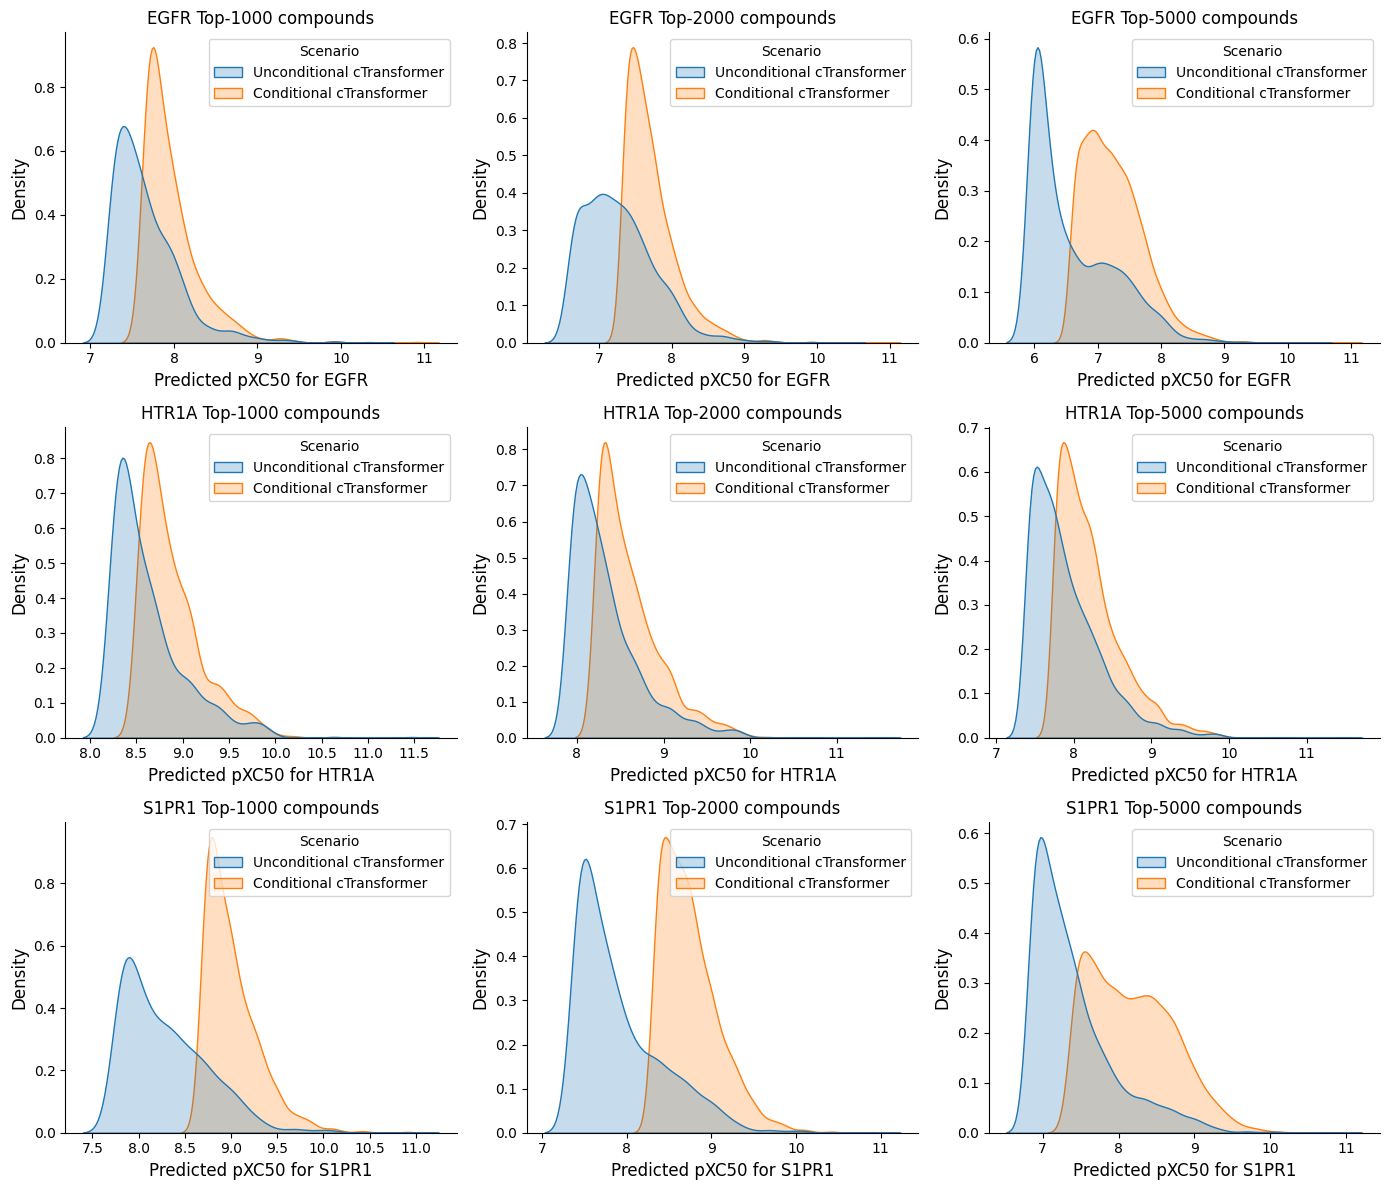

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pal=list(sns.color_palette("tab10"))

fig, axes = plt.subplots(3, 3, figsize=(14, 12))

names = [
    'EGFR',
    'HTR1A',
    'S1PR1'
]

num = [
    1000,
    2000,
    5000
]

for i, name in enumerate(names):
    for j, n in enumerate(num):
        unconditional = pd.DataFrame({
            'pred_pXC50': np.load('../generated_molecules/npy/{}_Unconditional_Y.npy'.format(name))
        }).sort_values(by=['pred_pXC50'],ascending=False).head(n)
        unconditional['Scenario']='Unconditional cTransformer'

        trans = pd.DataFrame(
            {'pred_pXC50':np.load('../generated_molecules/npy/{}_Conditional_Y.npy'.format(name))}
        ).sort_values(by=['pred_pXC50'],ascending=False).head(n)
        trans['Scenario']='Conditional cTransformer'

        df = pd.concat([unconditional, trans]).reset_index()
        sns.kdeplot(data=df, x="pred_pXC50", bw_adjust=1, hue='Scenario',ax=axes[i, j], fill=True)

        axes[i, j].set_title('{} Top-{} compounds'.format(name, n), fontsize=12)
        axes[i, j].spines['right'].set_visible(False)
        axes[i, j].spines['top'].set_visible(False)
        axes[i, j].set_ylabel("Density", fontsize=12)
        axes[i, j].set_xlabel(f"Predicted pXC50 for {name}", fontsize=12)

    plt.tight_layout()

plt.show()

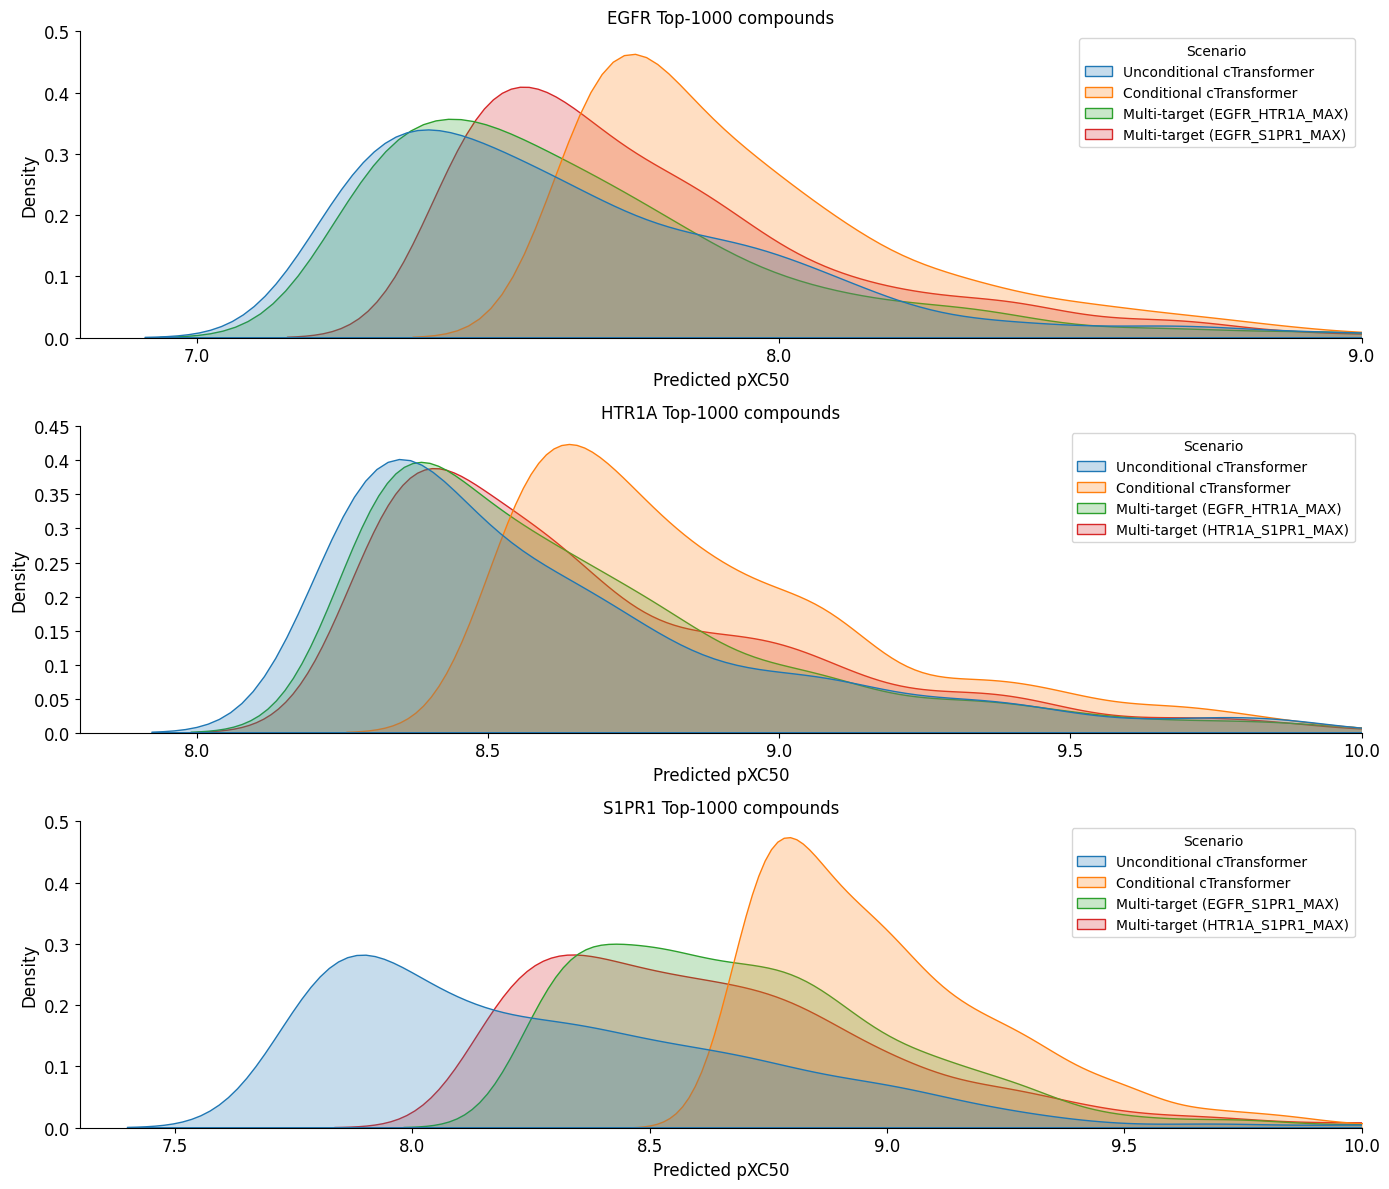

In [2]:
# Plot the multi-target distributions for the top 1000 compounds
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

agg = "MAX"

multi_targets = [
    f"EGFR_HTR1A_{agg}",
    f"EGFR_S1PR1_{agg}",
    f"HTR1A_S1PR1_{agg}"
]

n = 1000

names = [
    # 'Unconditional',
    ('EGFR', 6.8, 9),
    ('HTR1A', 7.8, 10),
    ('S1PR1', 7.3, 10)
]

for j, (name, min_x, max_x) in enumerate(names):
    df_list = []

    unconditional = pd.DataFrame({
        'pred_pXC50': np.load('../generated_molecules/npy/{}_Unconditional_Y.npy'.format(name))
    }).sort_values(by=['pred_pXC50'],ascending=False).head(n)
    unconditional['Scenario']='Unconditional cTransformer'
    df_list.append(unconditional)

    single_target = pd.DataFrame(
        {'pred_pXC50':np.load('../generated_molecules/npy/{}_Conditional_Y.npy'.format(name))}
    ).sort_values(by=['pred_pXC50'],ascending=False).head(n)
    single_target['Scenario']='Conditional cTransformer'
    df_list.append(single_target)

    for targets in multi_targets:
        if name in targets:
            multi_target = pd.DataFrame(
                {'pred_pXC50':np.load(f'../generated_molecules/npy/{targets}_Y_{name}.npy')}
            ).sort_values(by=['pred_pXC50'],ascending=False).head(n)
            multi_target['Scenario']=f'Multi-target ({targets})'
            df_list.append(multi_target)

    df = pd.concat(df_list).reset_index()

    sns.kdeplot(data=df, x="pred_pXC50", bw_adjust=1, hue='Scenario',ax=axes[j], fill=True)

    axes[j].set_title('{} Top-{} compounds'.format(name, n), fontsize=12)
    axes[j].spines['right'].set_visible(False)
    axes[j].spines['top'].set_visible(False)
    axes[j].set_ylabel("Density", fontsize=12)
    axes[j].set_xlabel("Predicted pXC50", fontsize=12)
    axes[j].yaxis.set_ticks(axes[j].get_yticks())
    axes[j].xaxis.set_ticks(axes[j].get_xticks())
    axes[j].set_yticklabels(axes[j].get_yticks().round(4), size=12)
    axes[j].set_xticklabels(axes[j].get_xticks().round(2), size=12)

    axes[j].set_xlim(min_x, max_x)

plt.tight_layout()
plt.show()

### Why does this approach seems to work for well for EGFR/S1PR1 target pair, but not for the pairs containing HTR1A?

In [3]:
import sys
import torch
from collections import namedtuple

sys.path.append('../')

from model_auto import Seq2SeqTransformer
from utils import read_delimited_file, read_csv_file
import vocabulary as mv

mol_list0_train = list(read_delimited_file('../train.smi'))
mol_list0_test = list(read_delimited_file('../test.smi'))

mol_list1, target_list = zip(*read_csv_file('../mol_target_dataloader/target.smi', num_fields=2))
mol_list = mol_list0_train
mol_list.extend(mol_list0_test) 
mol_list.extend(mol_list1)
vocabulary = mv.create_vocabulary(smiles_list=mol_list, tokenizer=mv.SMILESTokenizer())

BATCH_SIZE = 512
SRC_VOCAB_SIZE = len(vocabulary)
TGT_VOCAB_SIZE = len(vocabulary)

EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512

NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = DEVICE

args = namedtuple('args',['nhead'])(nhead=NHEAD)

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, 
                                EMB_SIZE, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE,
                                FFN_HID_DIM, args=args, emb_input_size=4)
transformer = transformer.to(device)
transformer.load_state_dict(torch.load('../model_finetune_original.h5'))

<All keys matched successfully>

In [4]:
target_to_key = {
    "EGFR": torch.tensor([0]).to(device),
    "HTR1A": torch.tensor([1]).to(device),
    "S1PR1": torch.tensor([2]).to(device)
}

target_embedding = dict()

for target in target_to_key:
    embedding = transformer.emb(target_to_key[target])
    target_embedding[target] = embedding

target_embedding["EGFR"].shape

torch.Size([1, 512])

In [5]:
# compute the cosine similarity between the target embeddings
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

similarity = dict()

for target1 in target_embedding:
    for target2 in target_embedding:
        similarity[f"{target1}_{target2}"] = cos(target_embedding[target1], target_embedding[target2])

similarity

{'EGFR_EGFR': tensor([1.0000], device='cuda:0', grad_fn=<SumBackward1>),
 'EGFR_HTR1A': tensor([-0.0028], device='cuda:0', grad_fn=<SumBackward1>),
 'EGFR_S1PR1': tensor([-0.0558], device='cuda:0', grad_fn=<SumBackward1>),
 'HTR1A_EGFR': tensor([-0.0028], device='cuda:0', grad_fn=<SumBackward1>),
 'HTR1A_HTR1A': tensor([1.0000], device='cuda:0', grad_fn=<SumBackward1>),
 'HTR1A_S1PR1': tensor([-0.1698], device='cuda:0', grad_fn=<SumBackward1>),
 'S1PR1_EGFR': tensor([-0.0558], device='cuda:0', grad_fn=<SumBackward1>),
 'S1PR1_HTR1A': tensor([-0.1698], device='cuda:0', grad_fn=<SumBackward1>),
 'S1PR1_S1PR1': tensor([1.], device='cuda:0', grad_fn=<SumBackward1>)}

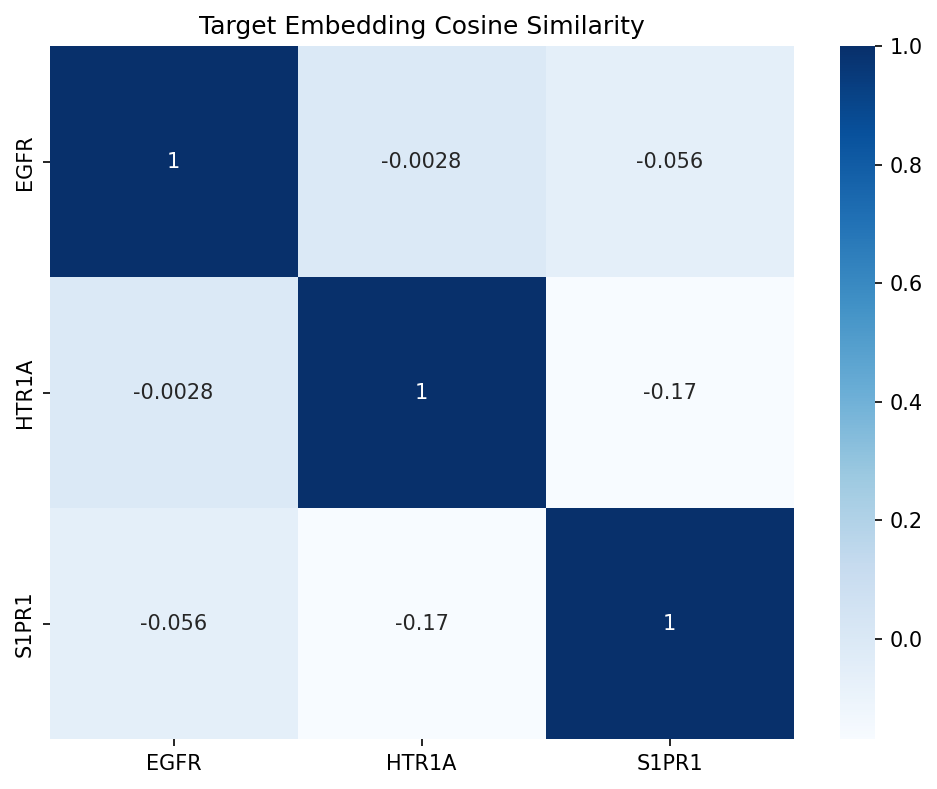

In [6]:
# plot the similarity matrix
import seaborn as sns

similarity_matrix = np.zeros((3, 3))

for i, target1 in enumerate(target_embedding):
    for j, target2 in enumerate(target_embedding):
        similarity_matrix[i, j] = similarity[f"{target1}_{target2}"].item()

plt.figure(figsize=(8, 6), dpi=150)

sns.heatmap(
    similarity_matrix, 
    annot=True, cmap='Blues',
    xticklabels=target_embedding.keys(), 
    yticklabels=target_embedding.keys()
)

plt.title('Target Embedding Cosine Similarity')

plt.show()

In [7]:
egfr_sequence = """MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEV
VLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALA
VLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDF
QNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGC
TGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYV
VTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFK
NCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAF
ENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKL
FGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCN
LLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVM
GENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPSIATGMVGALLLLLVV
ALGIGLFMRRRHIVRKRTLRRLLQERELVEPLTPSGEAPNQALLRILKETEFKKIKVLGS
GAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANKEILDEAYVMASVDNPHVCRLLGI
CLTSTVQLITQLMPFGCLLDYVREHKDNIGSQYLLNWCVQIAKGMNYLEDRRLVHRDLAA
RNVLVKTPQHVKITDFGLAKLLGAEEKEYHAEGGKVPIKWMALESILHRIYTHQSDVWSY
GVTVWELMTFGSKPYDGIPASEISSILEKGERLPQPPICTIDVYMIMVKCWMIDADSRPK
FRELIIEFSKMARDPQRYLVIQGDERMHLPSPTDSNFYRALMDEEDMDDVVDADEYLIPQ
QGFFSSPSTSRTPLLSSLSATSNNSTVACIDRNGLQSCPIKEDSFLQRYSSDPTGALTED
SIDDTFLPVPEYINQSVPKRPAGSVQNPVYHNQPLNPAPSRDPHYQDPHSTAVGNPEYLN
TVQPTCVNSTFDSPAHWAQKGSHQISLDNPDYQQDFFPKEAKPNGIFKGSTAENAEYLRV
APQSSEFIGA"""

htr1a_sequence = """MDVLSPGQGNNTTSPPAPFETGGNTTGISDVTVSYQVITSLLLGTLIFCAVLGNACVVAA
IALERSLQNVANYLIGSLAVTDLMVSVLVLPMAALYQVLNKWTLGQVTCDLFIALDVLCC
TSSILHLCAIALDRYWAITDPIDYVNKRTPRRAAALISLTWLIGFLISIPPMLGWRTPED
RSDPDACTISKDHGYTIYSTFGAFYIPLLLMLVLYGRIFRAARFRIRKTVKKVEKTGADT
RHGASPAPQPKKSVNGESGSRNWRLGVESKAGGALCANGAVRQGDDGAALEVIEVHRVGN
SKEHLPLPSEAGPTPCAPASFERKNERNAEAKRKMALARERKTVKTLGIIMGTFILCWLP
FFIVALVLPFCESSCHMPTLLGAIINWLGYSNSLLNPVIYAYFNKDFQNAFKKIIKCKFC
RQ"""

s1pr1_sequence = """MGPTSVPLVKAHRSSVSDYVNYDIIVRHYNYTGKLNISADKENSIKLTSVVFILICCFII
LENIFVLLTIWKTKKFHRPMYYFIGNLALSDLLAGVAYTANLLLSGATTYKLTPAQWFLR
EGSMFVALSASVFSLLAIAIERYITMLKMKLHNGSNNFRLFLLISACWVISLILGGLPIM
GWNCISALSSCSTVLPLYHKHYILFCTTVFTLLLLSIVILYCRIYSLVRTRSRRLTFRKN
ISKASRSSEKSLALLKTVIIVLSVFIACWAPLFILLLLDVGCKVKTCDILFRAEYFLVLA
VLNSGTNPIIYTLTNKEMRRAFIRIMSCCKCPSGDSAGKFKRPIIAGMEFSRSKSDNSSH
PQKDEGDNPETIMSSGNVNSSS"""

In [8]:
from Bio.Seq import Seq
from Bio.Align import PairwiseAligner

egfr_seq = Seq(egfr_sequence.replace('\n', ''))
htr1a_seq = Seq(htr1a_sequence.replace('\n', ''))
s1pr1_seq = Seq(s1pr1_sequence.replace('\n', ''))

targets_seq = {
    "EGFR": egfr_seq,
    "HTR1A": htr1a_seq,
    "S1PR1": s1pr1_seq
}

egfr_seq

Seq('MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFEDHFLSLQRM...IGA')

Alignment between EGFR and EGFR
Similarity: 1.00
Alignment between EGFR and HTR1A
Similarity: 0.21
Alignment between EGFR and S1PR1
Similarity: 0.20
Alignment between HTR1A and EGFR
Similarity: 0.59
Alignment between HTR1A and HTR1A
Similarity: 1.00
Alignment between HTR1A and S1PR1
Similarity: 0.35
Alignment between S1PR1 and EGFR
Similarity: 0.63
Alignment between S1PR1 and HTR1A
Similarity: 0.39
Alignment between S1PR1 and S1PR1
Similarity: 1.00


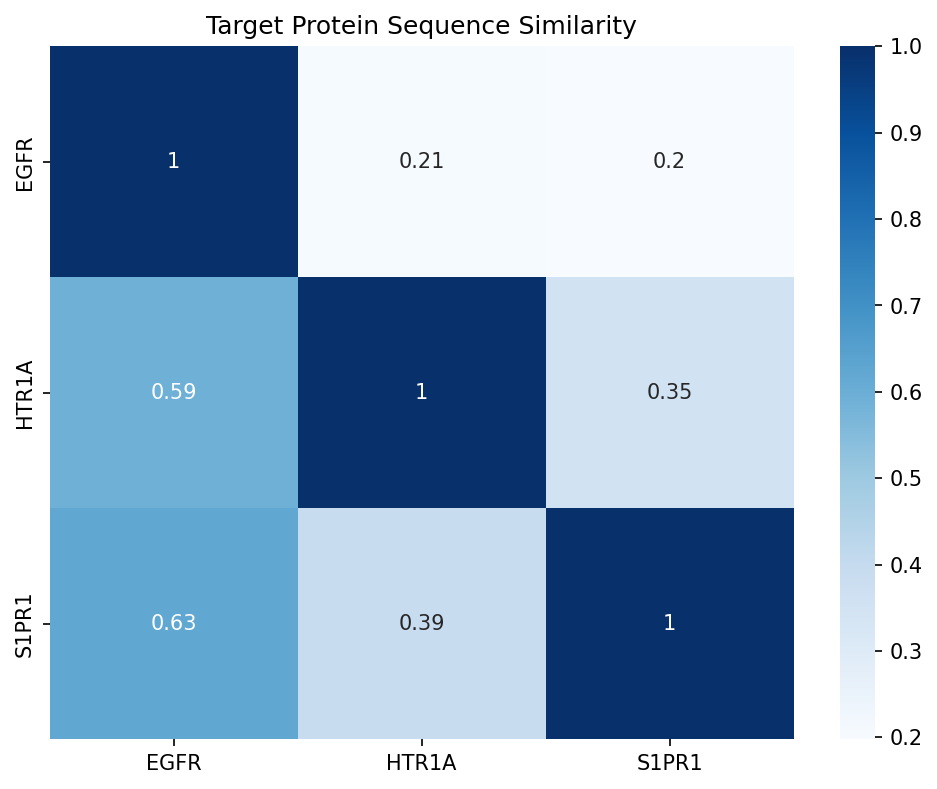

In [9]:
aligner = PairwiseAligner()

for target1 in targets_seq:
    for target2 in targets_seq:
        alignments = aligner.align(targets_seq[target1], targets_seq[target2])
        best_alignment = alignments[0]

        print(f"Alignment between {target1} and {target2}")
        # print(best_alignment)

        # Calculate sequence similarity as the fraction of identical residues
        similarity = best_alignment.score / len(targets_seq[target1])

        print(f"Similarity: {similarity:.2f}")

# plot the similarity matrix
similarity_matrix = np.zeros((3, 3))

for i, target1 in enumerate(targets_seq):
    for j, target2 in enumerate(targets_seq):
        alignments = aligner.align(targets_seq[target1], targets_seq[target2])
        best_alignment = alignments[0]

        similarity_matrix[i, j] = best_alignment.score / len(targets_seq[target1])

plt.figure(figsize=(8, 6), dpi=150)

sns.heatmap(
    similarity_matrix, 
    annot=True, cmap='Blues',
    xticklabels=targets_seq.keys(), 
    yticklabels=targets_seq.keys()
)

plt.title('Target Protein Sequence Similarity')

plt.show()

error1
error1
error1
error1
error1
error1
(5181, 2533) (5181,)
(6332, 2533) (6332,)
(1400, 2533) (1400,)


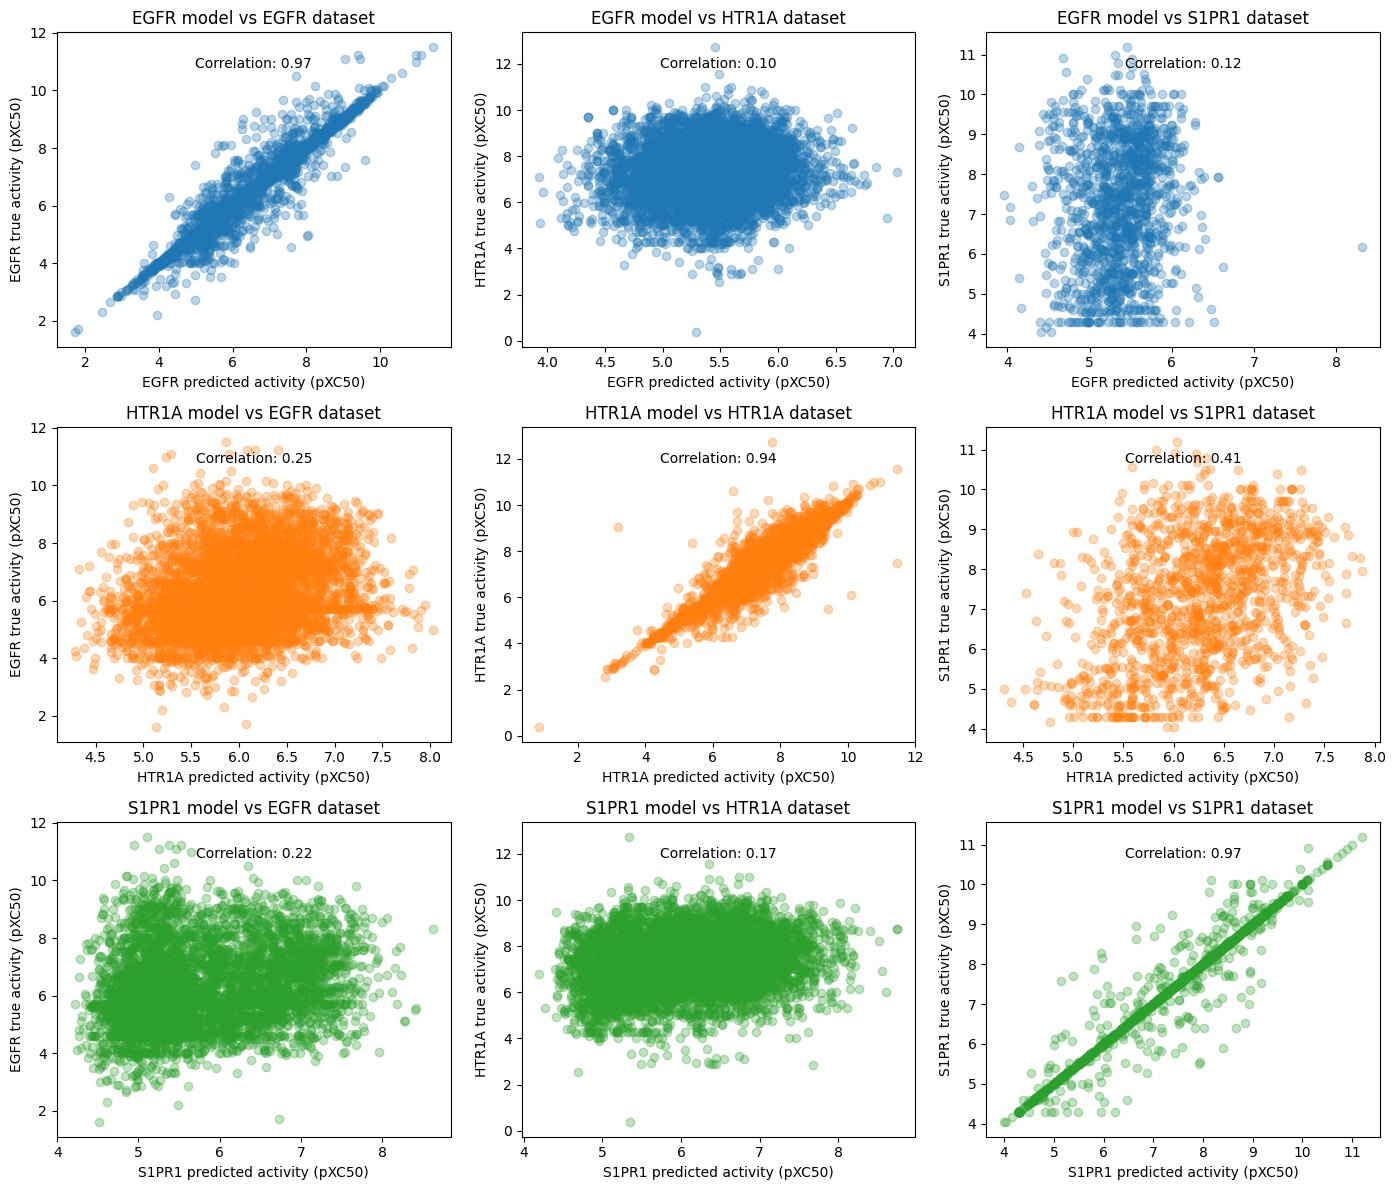

In [10]:
from rdkit import RDLogger

RDLogger.DisableLog('rdApp.*')

import lightgbm as lgb
from process_training_data import get_fp

# load qsar models for each target
targets = ["EGFR", "HTR1A", "S1PR1"]

model = dict()

for target in targets:
    model[target] = lgb.Booster(model_file=f'./model/{target}.txt')

# load active molecules dataset for each target
active_molecules = dict()

for target in targets:
    X = np.load('npy/{}_X.npy'.format(target))
    y = np.load('npy/{}_y.npy'.format(target))

    print(X.shape, y.shape)

    res = pd.DataFrame(X, columns=list(range(len(X[0]))))
    res['activity'] = y

    # res_active = res[res['activity'] >= 6.5]

    active_molecules[target] = res

# for each model, predict the activity of the active molecules datasets
predicted_activities = dict()

for target_model in targets:
    predicted_activities[target_model] = dict()

    for target_dataset in targets:
        X = active_molecules[target_dataset].drop(columns=['activity']).values
        y = active_molecules[target_dataset]['activity'].values

        predicted_activities[target_model][target_dataset] = model[target_model].predict(X)

# plot a scatter plot of the predicted activities for each target
# each row is a target model, each column is a target dataset
# the x axis is the predicted activity of the target model, the y axis is the predicted activity of the target dataset
fig, axes = plt.subplots(3, 3, figsize=(14, 12))

for i, target_model in enumerate(targets):
    for j, target_dataset in enumerate(targets):
        axes[i, j].scatter(
            predicted_activities[target_model][target_dataset], 
            active_molecules[target_dataset]['activity'], 
            # predicted_activities[target_dataset][target_dataset],
            alpha=0.3,
            color=pal[i]
        )

        axes[i, j].set_title(f'{target_model} model vs {target_dataset} dataset')
        axes[i, j].set_xlabel(f'{target_model} predicted activity (pXC50)')
        axes[i, j].set_ylabel(f'{target_dataset} true activity (pXC50)')

        # calculate the correlation coefficient
        correlation = np.corrcoef(
            predicted_activities[target_model][target_dataset], 
            active_molecules[target_dataset]['activity']
        )[0, 1]

        axes[i, j].text(0.5, 0.9, f'Correlation: {correlation:.2f}', 
                        horizontalalignment='center',
                        verticalalignment='center',
                        transform=axes[i, j].transAxes)


plt.tight_layout()
plt.show()

In [11]:
active_molecules_smiles = dict()
smiles_target = pd.read_csv("../mol_target_dataloader/target.smi", sep="\t", names=["SMILES", "target"])

targets_ids = {
    "EGFR": 1,
    "HTR1A": 2,
    "S1PR1": 3
}    

for target in targets_ids:
    _id = targets_ids[target]
    smiles_target_id = smiles_target[smiles_target["target"] == _id]
    active_molecules_smiles[target] = smiles_target_id.sample(500)

active_molecules_smiles

{'EGFR':                                                  SMILES  target
 822              COc1cc(C=C(C#N)C(=N)C(C#N)C#N)cc(O)c1O       1
 1321  Cc1cccc(NC(=O)Nc2ccc(-c3cnc4c(-c5cnn(C)c5)cnn4...       1
 959   CCOC1CNC(C#Cc2cc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(C...       1
 1177            COc1ccc(N(c2nc(C)nc3oc(C)cc23)C(C)C)cc1       1
 510   CN(CCO)Cc1ccn2ncnc(Nc3ccc4c(cnn4Cc4cccc(F)c4)c...       1
 ...                                                 ...     ...
 1269  Cc1ncnc(Nc2ccc(OCc3cccc(F)c3)c(Cl)c2)c1C=C(F)C...       1
 1282  NC1CCN(Cc2ccn3ncnc(Nc4ccc(OCc5cnccn5)c(Cl)c4)c...       1
 1084  Cc1cc(Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C)n2)c...       1
 1098  CC(=O)NC1CCN(Cc2ccn3ncnc(Nc4ccc5c(cnn5Cc5cccc(...       1
 448     Clc1ccc2c(Nc3ccc(-c4nc5ccccc5s4)c(Cl)c3)ncnc2c1       1
 
 [500 rows x 2 columns],
 'HTR1A':                                                  SMILES  target
 4632  COc1ccc(C(CCN2CCN(c3ccccc3OC)CC2)Oc2ccc(C(F)(F...       2
 4191  Oc1c2c(c(O)n1CCCCN1CCN(c3cccc(C(F)(F)F)

Text(0.5, 1.0, 'Tanimoto Similarity between Active Molecules Datasets')

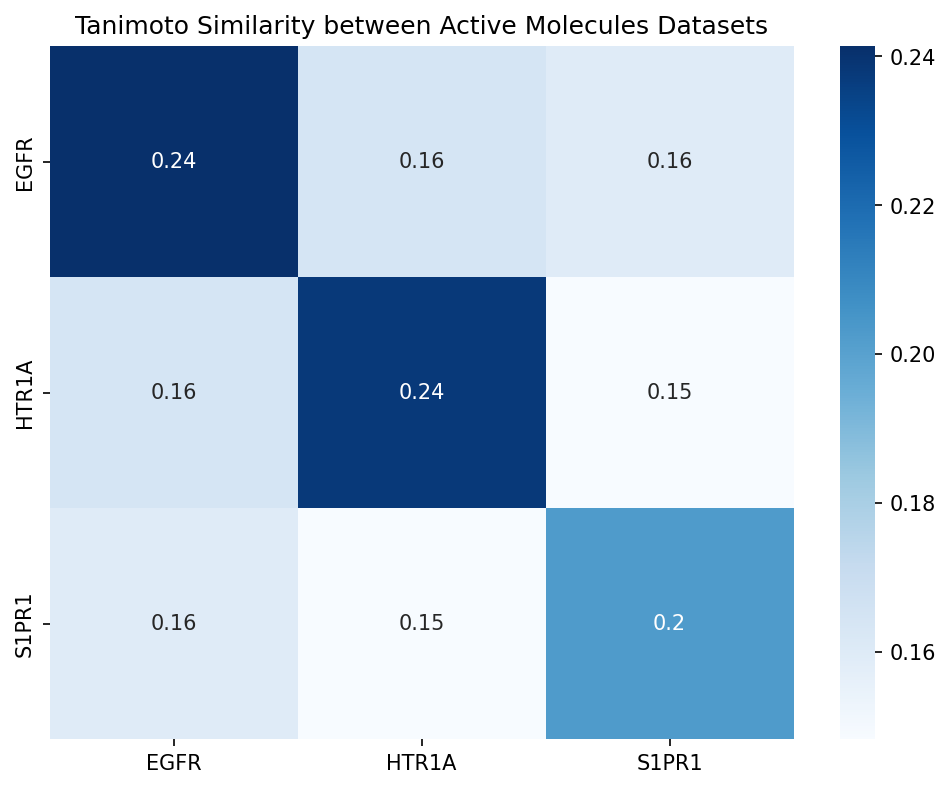

In [12]:
# import tanimoto bulk similarity
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import MolFromSmiles

# for each target, calculate the tanimoto similarity between the active molecules datasets
tanimoto_similarity = dict()

for target1 in targets:
    tanimoto_similarity[target1] = dict()

    for target2 in targets:
        tanimoto_similarity[target1][target2] = list()

        for smiles1 in active_molecules_smiles[target1]['SMILES']:
            mol1 = MolFromSmiles(smiles1)
            fp1 = AllChem.GetMorganFingerprint(mol1, 2)

            for smiles2 in active_molecules_smiles[target2]['SMILES']:
                mol2 = MolFromSmiles(smiles2)
                fp2 = AllChem.GetMorganFingerprint(mol2, 2)

                tanimoto_similarity[target1][target2].append(DataStructs.TanimotoSimilarity(fp1, fp2))

# plot the tanimoto similarity matrix
similarity_matrix = np.zeros((3, 3))

for i, target1 in enumerate(targets):
    for j, target2 in enumerate(targets):
        similarity_matrix[i, j] = np.mean(tanimoto_similarity[target1][target2])

plt.figure(figsize=(8, 6), dpi=150)

sns.heatmap(
    similarity_matrix, 
    annot=True, cmap='Blues',
    xticklabels=targets, 
    yticklabels=targets
)

plt.title('Tanimoto Similarity between Active Molecules Datasets')

#### Tree MAP

In [13]:
all_active_molecules = pd.DataFrame()

for target in targets:
    mols_df = active_molecules_smiles[target]
    mols_df['target'] = target

    all_active_molecules = pd.concat([all_active_molecules, mols_df])

all_active_molecules

,SMILES,target
822,COc1cc(C=C(C#N)C(=N)C(C#N)C#N)cc(O)c1O,EGFR
1321,Cc1cccc(NC(=O)Nc2ccc(-c3cnc4c(-c5cnn(C)c5)cnn4...,EGFR
959,CCOC1CNC(C#Cc2cc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(C...,EGFR
1177,COc1ccc(N(c2nc(C)nc3oc(C)cc23)C(C)C)cc1,EGFR
510,CN(CCO)Cc1ccn2ncnc(Nc3ccc4c(cnn4Cc4cccc(F)c4)c...,EGFR
...,...,...
5271,COc1ccc(N2C(=O)C(=Cc3ccc(O)c(Cl)c3)SC2=NC(C)C)cc1,S1PR1
5427,Cc1ccc(CC(CCCSc2ccc(CNCCCP(=O)(O)O)cc2)c2cc(F)...,S1PR1
5624,CCc1cc(-c2noc(-c3sc(CC)c4c3CCC3(CC3)C4)n2)cc(C...,S1PR1
5394,Cc1cc(CCC(=O)O)ccc1-c1nnc(-c2ccc(OC(C(F)(F)F)C...,S1PR1


In [14]:
for i, row in all_active_molecules.iterrows():
    print(row['SMILES'], row['target'])
    print(row)
    break

COc1cc(C=C(C#N)C(=N)C(C#N)C#N)cc(O)c1O EGFR
SMILES    COc1cc(C=C(C#N)C(=N)C(C#N)C#N)cc(O)c1O
target                                      EGFR
Name: 822, dtype: object


In [47]:
training_mols = pd.read_csv(
    "../mol_target_dataloader/target.smi", sep="\t", names=["SMILES", "target"]
)
training_mols["target"] = training_mols["target"].replace(
    {1: "EGFR", 2: "HTR1A", 3: "S1PR1"}
)

targets = ["EGFR", "HTR1A", "S1PR1"]

for target in targets:
    transformers = pd.DataFrame({
        'SMILES': pd.read_csv('../generated_molecules/smiles/{}.smi'.format(target))["SMILES"],
        'pred_pXC50': np.load('../generated_molecules/npy/{}_Conditional_Y.npy'.format(target))
    })

    smiles_top_3000 = transformers.sort_values(
        by=['pred_pXC50'],ascending=False
    ).head(3000)

    smiles_top_3000['target'] = f"{target} (generated)"
    generated_mols = smiles_top_3000[["SMILES", "target"]]

    training_mols = pd.concat([training_mols, generated_mols])

training_mols["target"].value_counts()

HTR1A                3485
EGFR (generated)     3000
HTR1A (generated)    3000
S1PR1 (generated)    3000
EGFR                 1381
S1PR1                 795
Name: target, dtype: int64

In [48]:
# add multi-target generated molecules
agg = "SUM"

multi_targets = [
    (f"EGFR_HTR1A_{agg}", "EGFR", "HTR1A"),
    (f"EGFR_S1PR1_{agg}", "EGFR", "S1PR1"),
    (f"HTR1A_S1PR1_{agg}", "HTR1A", "S1PR1")
]

for (mt, t1, t2) in multi_targets:
    transformers = pd.DataFrame({
        'SMILES': pd.read_csv(f'../generated_molecules/smiles/{mt}.smi')["SMILES"],
        'pred_pXC50_T1': np.load(f'../generated_molecules/npy/{mt}_Y_{t1}.npy'),
        'pred_pXC50_T2': np.load(f'../generated_molecules/npy/{mt}_Y_{t2}.npy')
    })

    transformers['pred_pXC50'] = transformers[['pred_pXC50_T1', 'pred_pXC50_T2']].mean(axis=1)

    smiles_top_3000 = transformers.sort_values(
        by=['pred_pXC50'],ascending=False
    ).head(3000)

    smiles_top_3000['target'] = f"{mt}"
    generated_mols = smiles_top_3000[["SMILES", "target"]]

    training_mols = pd.concat([training_mols, generated_mols])

In [49]:
training_mols["target"].value_counts()

HTR1A                3485
EGFR (generated)     3000
HTR1A (generated)    3000
S1PR1 (generated)    3000
EGFR_HTR1A_SUM       3000
EGFR_S1PR1_SUM       3000
HTR1A_S1PR1_SUM      3000
EGFR                 1381
S1PR1                 795
Name: target, dtype: int64

In [55]:
import numpy as np
import tmap as tm
import pandas as pd
import scipy.stats as ss
from rdkit.Chem import AllChem
from mhfp.encoder import MHFPEncoder
from faerun import Faerun
from collections import Counter
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt
from IPython.display import IFrame

filter_types = [
    "EGFR",
    # "HTR1A",
    "S1PR1",
    "EGFR (generated)",
    # "HTR1A (generated)",
    "S1PR1 (generated)",
    # "EGFR_HTR1A_SUM",
    "EGFR_S1PR1_SUM",
    # "HTR1A_S1PR1_SUM"
]

colors = {
    "EGFR": "green",
    "EGFR (generated)": "darkgreen",
    # green + red
    "EGFR_HTR1A_SUM": "yellow",
    # green + blue
    "EGFR_S1PR1_SUM": "cyan",
    "HTR1A": "red",
    "HTR1A (generated)": "darkred",
    # red + blue
    "HTR1A_S1PR1_SUM": "magenta",
    "S1PR1": "blue",
    "S1PR1 (generated)": "darkblue",
}

def main():
    """ Main funciton """
    # df = all_active_molecules
    df = training_mols.query("target in @filter_types")

    enc = MHFPEncoder(1024)
    lf = tm.LSHForest(1024, 64)

    fps = []
    hac = []
    c_frac = []
    ring_atom_frac = []
    largest_ring_size = []

    for i, row in df.iterrows():
        if i != 0 and i % 1000 == 0:
            print(f"{i / len(df):0.2%} done")
        mol = AllChem.MolFromSmiles(row["SMILES"])
        atoms = mol.GetAtoms()
        size = mol.GetNumHeavyAtoms()
        n_c = 0
        n_ring_atoms = 0
        for atom in atoms:
            if atom.IsInRing():
                n_ring_atoms += 1
            if atom.GetSymbol().lower() == "c":
                n_c += 1

        c_frac.append(n_c / size)
        ring_atom_frac.append(n_ring_atoms / size)
        sssr = AllChem.GetSymmSSSR(mol)
        if len(sssr) > 0:
            largest_ring_size.append(max([len(s) for s in sssr]))
        else:
            largest_ring_size.append(0)
        hac.append(size)
        fps.append(tm.VectorUint(enc.encode_mol(mol)))

    lf.batch_add(fps)
    lf.index()

    c_frak_ranked = ss.rankdata(np.array(c_frac) / max(c_frac)) / len(c_frac)

    cfg = tm.LayoutConfiguration()
    cfg.node_size = 1 / 26
    cfg.mmm_repeats = 2
    cfg.sl_extra_scaling_steps = 5
    cfg.k = 20
    cfg.sl_scaling_type = tm.RelativeToAvgLength
    x, y, s, t, _ = tm.layout_from_lsh_forest(lf, cfg)

    type_labels, type_data = Faerun.create_categories(df["target"])

    cmap = ListedColormap([colors[t[1]] for t in type_labels])

    # tab_10 = plt.cm.get_cmap("tab10")
    # colors = [i for i in tab_10.colors]
    # colors[7] = (0.17, 0.24, 0.31)
    # tab_10.colors = tuple(colors)

    f = Faerun(view="front", coords=False)
    f.add_scatter(
        "np_atlas",
        {
            "x": x,
            "y": y,
            "c": [
                type_data,
            ],
            "labels": df["SMILES"],
        },
        shader="smoothCircle",
        point_scale=2.0,
        max_point_size=20,
        legend_labels=[type_labels],
        categorical=[True],
        colormap=[cmap],
        series_title=[
            "Type",
        ],
        has_legend=True,
    )
    f.add_tree("np_atlas_tree", {"from": s, "to": t}, point_helper="np_atlas")
    f.plot(template="smiles")

main()

8.95% done
44.74% done
62.63% done
8.95% done
89.48% done
8.95% done
26.84% done
44.74% done


/home/arthurcerveira/cMolGPT/qsar/index.html

In [51]:
type_labels, type_data = Faerun.create_categories(training_mols["target"])

In [52]:
type_labels

[(0, 'EGFR'),
 (1, 'EGFR (generated)'),
 (2, 'EGFR_HTR1A_SUM'),
 (3, 'EGFR_S1PR1_SUM'),
 (4, 'HTR1A'),
 (5, 'HTR1A (generated)'),
 (6, 'HTR1A_S1PR1_SUM'),
 (7, 'S1PR1'),
 (8, 'S1PR1 (generated)')]

In [41]:
from IPython.display import display, HTML

# IFrame("index.html", width=700, height=600)
display(HTML(open('index.html').read(), metadata=dict(isolated=False)))

In [ ]:
import tmap

# plot the tmap for the active molecules datasets
tmap = tmap.TMAP()

for target in targets:
    tmap.add_dataset(
        active_molecules_smiles[target]['SMILES'], 
        target
    )

tmap.plot()